In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from TimeSeriesDatasetGenerater  import TimeSeriesDatasetGenerater
import torch
import torch.nn as nn
import torch.nn.functional as F

c:\Users\PorallaPradhyumna\.conda\envs\env_rl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\PorallaPradhyumna\.conda\envs\env_rl\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\PorallaPradhyumna\.conda\envs\env_rl\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Replace 'your_file.xlsx' with the actual path to your Excel file
excel_file_path = 'D:\Programs\DeepLearing\Stock_prize_Prediction\Data\Stocks.xlsx'

# Read all sheets into a dictionary of DataFrames
all_sheets = pd.read_excel(excel_file_path, sheet_name=None)

# Now, all_sheets is a dictionary where keys are sheet names and values are DataFrames
# You can access a specific sheet using its name, for example:
first_sheet_name = list(all_sheets.keys())
#first_sheet_data = all_sheets[first_sheet_name]
print(first_sheet_name)
# Print the data in the first sheet
#print(f"Data in the sheet '{first_sheet_name}':\n", first_sheet_data)

['Amazon', 'S&P 500', 'NIFTY_50', 'NIFTY BANK', 'Dow Jones Industrial Average', 'Nasdaq Composite', 'Apple INC', 'Google', 'Microsoft Corp', 'Netflix Inc', 'Salesforce Inc']


In [3]:
df_amazon= all_sheets[first_sheet_name[0]]
df_amazon.head()

,Date,Open,High,Low,Close,Volume
0,1997-05-16 16:00:00.288,0.10,0.10,0.09,0.09,1223800
1,1997-05-19 16:00:00.288,0.09,0.09,0.08,0.09,508900
2,1997-05-20 16:00:00.288,0.09,0.09,0.08,0.08,455600
3,1997-05-21 16:00:00.288,0.08,0.08,0.07,0.07,1571100
4,1997-05-22 16:00:00.288,0.07,0.07,0.07,0.07,981400


In [4]:
df_amazon = df_amazon[df_amazon['Date'].dt.year>2018]

In [5]:
df_amazon.shape

(1065, 6)

In [6]:
df_amazon = df_amazon.drop('Date', axis=1)

In [7]:
means = df_amazon.mean(axis=0)
df_amazon -= means
std = df_amazon.std(axis=0)
df_amazon /= std

In [8]:
df_amazon.shape
#df_amazon = df_amazon.drop('Date', axis=1)


(1065, 5)

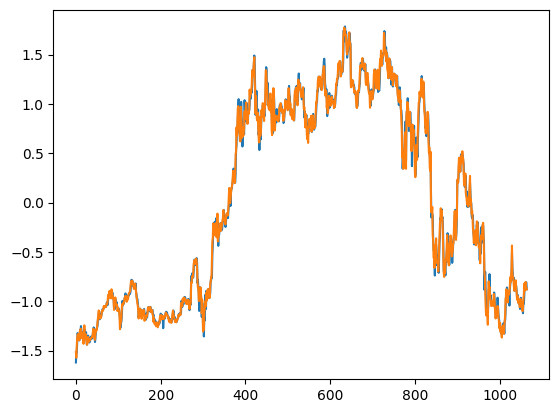

In [9]:
plt.plot(range(df_amazon.shape[0]), df_amazon['Open'])
plt.plot(range(df_amazon.shape[0]), df_amazon['Close'])

In [10]:
# Split the dataframe into train and test sets
train_size = int(0.8 * len(df_amazon))
train_df = df_amazon.iloc[:train_size]
test_df = df_amazon.iloc[train_size:]


In [11]:
sampling_rate = 2
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
data = train_df.iloc[:-delay].to_numpy()
targets = train_df['Open'].iloc[delay:].to_numpy()

In [12]:
data.shape,targets.shape#45010

((566, 5), (566,))

In [13]:
sampling_rate = 2
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
dataset = TimeSeriesDatasetGenerater(data, targets, sequence_length, sequence_stride=2, sampling_rate = sampling_rate, batch_size = batch_size, shuffle = False, seed=None, start_index=0, end_index=566-sequence_length)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=dataset.batch_size, shuffle=dataset.shuffle)

In [14]:
import math
class SelfAttention(nn.Module):
    def __init__(self,n_heads, d_embed, in_proj_bais = True, out_proj_bais =True):
        super(SelfAttention, self).__init__()
        self.n_heads = n_heads
        self.d_heads = d_embed//n_heads
        
        
        self.q = nn.Linear(d_embed,d_embed,bias=in_proj_bais)
        self.k = nn.Linear(d_embed,d_embed,bias=in_proj_bais)
        self.v = nn.Linear(d_embed,d_embed,bias=in_proj_bais)
        
        self.out_proj = nn.Linear(d_embed,d_embed,bias=out_proj_bais)
        
    def forward(self, x,causal_mask=False):
        # x: batch_size, features, dim
        bs, seq_len, d_embed = x.shape
        intermedate_shape = (bs, seq_len,self.n_heads,self.d_heads)
        q= F.silu(self.q(x))
        k= F.silu(self.k(x))
        v= F.silu(self.v(x))
        
        q = q.view(intermedate_shape).transpose(1,2)
        k = k.view(intermedate_shape).transpose(1,2)
        v = v.view(intermedate_shape).transpose(1,2)
        
        #(Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) => (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1,-2)
        
        if causal_mask:
            mask = torch.ones_like(weight,dtype=torch.bool).triu(1)
            weight.masked_fill_(mask,-torch.inf)
        
        weight /= math.sqrt(self.d_heads)
        
        weight = F.softmax(weight,dim=-1)
        #(Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) ==> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v
        
        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2) 
        
        #(Batch_Size, Seq_Len, H, Dim / H) ==> (Batch_Size, Seq_Len, Dim)
        output =  output.reshape((bs, seq_len, d_embed))
        
        output = self.out_proj(output)
        return output

In [20]:
class NavieModel(nn.Module):
    def __init__(self):
        super(NavieModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=120, out_channels=240, kernel_size=3, padding=1)
        self.bact_norm = nn.BatchNorm1d(240,momentum=1e-3)
        self.lstm = nn.LSTM(input_size=5, hidden_size=240, batch_first=True,dropout=0.2)
        self.attention = SelfAttention(6,240)
        self.layer_norm_1 = nn.LayerNorm(480)
        
        
        self.ff_1 = nn.Linear(480,480*2)
        self.ff_2 = nn.Linear(480*2,480)
        self.ff_3 = nn.Linear(480,480//2)
        self.layer_norm_2 = nn.LayerNorm(960)
        
        self.lin_1 = nn.Linear(960,960//2)
        self.lin_2 = nn.Linear(960//2,120)
        
        self.conv1d_1 = nn.Conv1d(240,120,kernel_size=3,stride=2)
        self.conv1d_2 = nn.Conv1d(120,1,kernel_size=3,stride=2)
        
        #self.group_pool = nn.GlobalAveragePooling()
        
        self.op = nn.Linear(120,1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.bact_norm(x)
        x, _ = self.lstm(x)
        residual = x
        x = self.attention(x)
        x = torch.cat((x,residual),dim=-1)
        x = self.layer_norm_1(x)
        residual = x
        x = F.relu(self.ff_1(x))
        x = F.relu(self.ff_2(x))
        x = torch.cat((x,residual),dim=-1)
        x = self.layer_norm_2(x)
        
        x = F.relu(self.lin_1(x))
        x = F.relu(self.lin_2(x))
        
        x = F.relu6(self.conv1d_1(x))
        x = F.relu6(self.conv1d_2(x))
        
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.shape[0], -1)
        #x = self.group_pool(x)
        #x = F.relu(self.op(x))
        #print(x.shape)
        #x = self.lin(x)
        return x

In [21]:
NM = NavieModel().to('cuda')
optima = torch.optim.SGD(NM.parameters(), lr=0.01)
loss_function = nn.MSELoss()


In [17]:
from tqdm import tqdm

In [18]:
for batch in tqdm(dataloader):
    x,y = batch
    print(x.shape, y.shape)
    break

  0%|          | 0/196 [00:00<?, ?it/s]

torch.Size([256, 120, 5]) torch.Size([256])


In [24]:
epochs = 10
for epoch in range(epochs):
    
    for batch in tqdm(dataloader):
        x,y = batch
        x=x.to('cuda').float()
        y=y.to('cuda').float()
        x_ = NM(x)
        loss = loss_function(x_, y)
        optima.zero_grad()
        loss.backward()
        optima.step()
    print(f'Epoch:{epoch+1},Loss:{loss :.4f}',end="")
    

100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Epoch:1,Loss:0.2763

100%|██████████| 196/196 [00:56<00:00,  3.49it/s]


Epoch:2,Loss:0.2413

100%|██████████| 196/196 [00:56<00:00,  3.49it/s]


Epoch:3,Loss:0.1964

100%|██████████| 196/196 [03:44<00:00,  1.15s/it] 


Epoch:4,Loss:0.1931

100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch:5,Loss:0.1924

100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch:6,Loss:0.1922

100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch:7,Loss:0.1912

100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch:8,Loss:0.1911

100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch:9,Loss:0.1907

100%|██████████| 196/196 [00:56<00:00,  3.50it/s]

Epoch:10,Loss:0.1901